In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk


# Load the CSV file
print("Loading dataset...")
df = pd.read_csv("task_dataset.csv")
print("\nInitial data shape:", df.shape)
print("\n\n")
print(df.head().to_string(index=False, justify='center'))

# Check for missing values
print("\n\n\nMissing values:")
print(df.isnull().sum())

# Drop rows with missing task or category
df.dropna(subset=['task', 'category', 'priority'], inplace=True)


# Text Cleaning

def clean_text(text):
    text = str(text).lower()                            # Lowercase
    text = re.sub(r'\n', ' ', text)                    # Remove newlines
    text = re.sub(r'http\S+', '', text)                # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)         # Remove punctuation/symbols
    text = re.sub(r'\s+', ' ', text).strip()           # Remove extra whitespaces
    return text


# Apply cleaning to task and category
print("\n\n\nApplying cleaning to task and category fields...")
df['task_clean'] = df['task'].apply(clean_text)
df['category_clean'] = df['category'].apply(clean_text)

# Length of each task
print("Adding task length features...")
df['char_count'] = df['task_clean'].apply(len)
df['word_count'] = df['task_clean'].apply(lambda x: len(x.split()))


# tokenization, stemming and stopword removal
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def tokenize_stem(text):
    tokens = word_tokenize(text)
    filtered = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(filtered)
print("\n\nApplying tokenization, stop word removal, and stemming...\n\n")
df['task_processed'] = df['task_clean'].apply(tokenize_stem)

# Numerical mapping for priority
print("Mapping priority to numeric values (Low=0, Medium=1, High=2)...")
priority_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['priority_numeric'] = df['priority'].map(priority_map)

# ----------------------------
# Encode category labels
# ----------------------------
print("Encoding category labels...")
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category_clean'])

# ----------------------------
# Show processed data
# ----------------------------
print("\nCleaned and processed data sample:-")
print(df[['task_clean','task_processed', 'category_clean', 'category_encoded','priority_numeric', 'char_count', 'word_count']].head(10).to_string(index=False, justify='center'))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure inline plotting (for Jupyter Notebook)
%matplotlib inline


In [ ]:
plt.figure(figsize=(8,4))
df['category_clean'].value_counts().plot(kind='bar', color='navy')
plt.title("Task Category Distribution", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Tasks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
df['priority'].value_counts().plot(kind='bar', color='salmon')
plt.title("Task Priority Distribution", fontsize=14)
plt.xlabel("Priority")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], kde=True, bins=30, color='purple')
plt.title("Distribution of Task Word Counts", fontsize=14)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
avg_len = df.groupby('category_clean')['word_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
avg_len.plot(kind='bar', color='green')
plt.title("Average Word Count per Category", fontsize=14)
plt.ylabel("Avg. Word Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
text_all = " ".join(df['task_processed'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in All Tasks", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
print("Extracting TF-IDF features...")
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['task_processed'])

# Target: Category (encoded)
y = df['category_encoded']
print("TF-IDF feature matrix shape:", X.shape)


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_cat_train, y_cat_test, y_prio_train, y_prio_test = train_test_split(
    X, df['category_encoded'], df['priority_numeric'], test_size=0.2, random_state=42)


In [46]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


'''Naive Bayes model'''
nb_model = MultinomialNB()
nb_model.fit(X_train, y_cat_train)

y_pred_nb = nb_model.predict(X_test)



'''SVM model'''
svm_model = LinearSVC()
svm_model.fit(X_train, y_cat_train)

y_pred_svm = svm_model.predict(X_test)


In [34]:
# Evaluation

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Naive Bayes Classification Report:")
print(classification_report(y_cat_test, y_pred_nb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_cat_test, y_pred_nb))

print(" \n\nSVM Classification Report:")
print(classification_report(y_cat_test, y_pred_svm, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_cat_test, y_pred_svm))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    academic       1.00      1.00      1.00        49
     finance       1.00      1.00      1.00        57
      health       0.98      1.00      0.99        60
    personal       1.00      0.92      0.96        48
        work       0.92      1.00      0.96        36

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

Accuracy: 0.984
 

SVM Classification Report:
              precision    recall  f1-score   support

    academic       1.00      1.00      1.00        49
     finance       1.00      1.00      1.00        57
      health       1.00      1.00      1.00        60
    personal       1.00      1.00      1.00        48
        work       1.00      1.00      1.00        36

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       

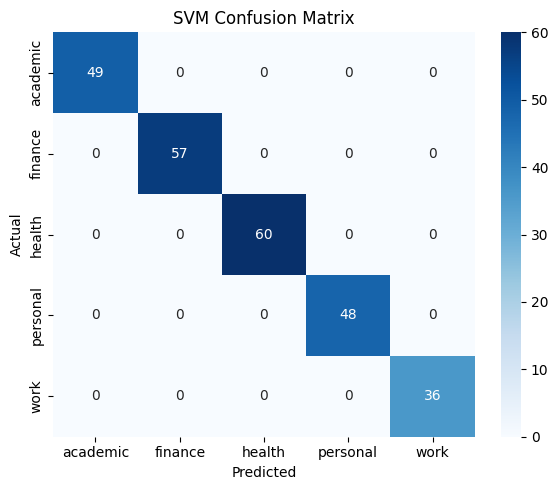

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix for SVM
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_cat_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [53]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

''' Random Forest model'''
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_prio_train)

yp_pred_rf = rf_model.predict(X_test)

''' XGBoost model '''
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_prio_train)

yp_pred_xgb = xgb_model.predict(X_test)


In [54]:
# Evaluation
print(" Random Forest - Priority Classification Report")
print(classification_report(y_prio_test, yp_pred_rf))
print("Accuracy:", accuracy_score(y_prio_test, yp_pred_rf))


print(" XGBoost - Priority Classification Report")
print(classification_report(y_prio_test, yp_pred_xgb))
print("Accuracy:", accuracy_score(y_prio_test, yp_pred_xgb))


 Random Forest - Priority Classification Report
              precision    recall  f1-score   support

           0       0.30      0.29      0.29        21
           1       0.44      0.57      0.50        42
           2       0.35      0.24      0.29        37

    accuracy                           0.39       100
   macro avg       0.36      0.37      0.36       100
weighted avg       0.38      0.39      0.38       100

Accuracy: 0.39
 XGBoost - Priority Classification Report
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        21
           1       0.43      0.55      0.48        42
           2       0.36      0.27      0.31        37

    accuracy                           0.40       100
   macro avg       0.39      0.38      0.38       100
weighted avg       0.39      0.40      0.39       100

Accuracy: 0.4


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Random Forest Grid Search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    cv=3, scoring='accuracy', n_jobs=-1
)
rf_grid.fit(Xp_train, yp_train)
print("Best RF Params:", rf_grid.best_params_)
print("RF Accuracy:", rf_grid.best_score_)

# XGBoost Grid Search
xgb_grid = GridSearchCV(
    XGBClassifier(eval_metric='mlogloss',random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.01]
    },
    cv=3, scoring='accuracy', n_jobs=-1
)
xgb_grid.fit(Xp_train, yp_train)
print("\n\nBest XGB Params:", xgb_grid.best_params_)
print("XGB Accuracy:", xgb_grid.best_score_)


Best RF Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
RF Accuracy: 0.4825309542512999


Best XGB Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGB Accuracy: 0.4474806419032656


In [52]:
# Replace original models with best estimators
rf_model = rf_grid.best_estimator_
xgb_model = xgb_grid.best_estimator_

# Re-predict using best models (optional, if not done before)
yp_pred_rf = rf_model.predict(Xp_test)
yp_pred_xgb = xgb_model.predict(Xp_test)

# Evaluate updated models
rf_accuracy = accuracy_score(y_prio_test, yp_pred_rf)
xgb_accuracy = accuracy_score(y_prio_test, yp_pred_xgb)

print("\n✅ Finalized Priority Model Accuracies:")
print(f"   • Random Forest (Best) : {rf_accuracy:.4f}")
print(f"   • XGBoost (Best)       : {xgb_accuracy:.4f}")



✅ Finalized Priority Model Accuracies:
   • Random Forest (Best) : 0.4000
   • XGBoost (Best)       : 0.3900


In [56]:
from sklearn.metrics import accuracy_score

# ✅ Accuracies for Category Predictions
nb_acc = accuracy_score(y_cat_test, y_pred_nb)       # Naive Bayes
svm_acc = accuracy_score(y_cat_test, y_pred_svm)     # SVM

# ✅ Accuracies for Priority Predictions
rf_acc = accuracy_score(y_prio_test, yp_pred_rf)     # Random Forest
xgb_acc = accuracy_score(y_prio_test, yp_pred_xgb)   # XGBoost

# ✅ Display Accuracies
print("📂 Category Prediction Accuracies:")
print(f"   • Naive Bayes : {nb_acc:.4f}")
print(f"   • SVM         : {svm_acc:.4f}")

print("\n⚠️ Priority Prediction Accuracies:")
print(f"   • Random Forest : {rf_acc:.4f}")
print(f"   • XGBoost       : {xgb_acc:.4f}")


📂 Category Prediction Accuracies:
   • Naive Bayes : 0.9900
   • SVM         : 1.0000

⚠️ Priority Prediction Accuracies:
   • Random Forest : 0.3900
   • XGBoost       : 0.4000


In [51]:
from sklearn.metrics import accuracy_score

# ✅ Category Prediction Accuracies (already trained models)
nb_acc = accuracy_score(y_cat_test, y_pred_nb)       
svm_acc = accuracy_score(y_cat_test, y_pred_svm)     

# ✅ Priority Prediction Accuracies using best estimators
yp_pred_rf_best = rf_grid.best_estimator_.predict(Xp_test)
yp_pred_xgb_best = xgb_grid.best_estimator_.predict(Xp_test)

rf_acc_best = accuracy_score(y_prio_test, yp_pred_rf_best)
xgb_acc_best = accuracy_score(y_prio_test, yp_pred_xgb_best)

# ✅ Display Accuracies
print("📂 Category Prediction Accuracies:")
print(f"   • Naive Bayes : {nb_acc:.4f}")
print(f"   • SVM         : {svm_acc:.4f}")

print("\n⚠️ Priority Prediction Accuracies (Best Estimators):")
print(f"   • Random Forest (Best) : {rf_acc_best:.4f}")
print(f"   • XGBoost (Best)       : {xgb_acc_best:.4f}")


📂 Category Prediction Accuracies:
   • Naive Bayes : 0.9900
   • SVM         : 1.0000

⚠️ Priority Prediction Accuracies (Best Estimators):
   • Random Forest (Best) : 0.4000
   • XGBoost (Best)       : 0.3900


In [68]:
def predicter(task_text):
    # Preprocess like your pipeline
    task_clean = task_text.lower().strip()
    task_vec = tfidf.transform([task_clean])  # single row

    # Category Prediction
    nb_pred = label_encoder.inverse_transform(nb_model.predict(task_vec))[0]
    svm_pred = label_encoder.inverse_transform(svm_model.predict(task_vec))[0]

    # Priority Prediction
    xgb_pred = xgb_model.predict(task_vec)[0]
    rf_pred = rf_model.predict(task_vec)[0]

    # Priority mapping
    priority_map = {2: "High", 1: "Medium", 0: "Low"}

    # Output
    print("Task:", task_text)
    print("\nPredicted Category:")
    print("   • Naive Bayes →", nb_pred)
    print("   • SVM         →", svm_pred)

    print("\nPredicted Priority:")
    print("   • Random Forest →", priority_map.get(rf_pred, "Unknown"))
    print("   • XGBoost       →", priority_map.get(xgb_pred, "Unknown"))

tasker = input("enter task: ")
predicter(tasker)

enter task:  help your wife


Task: help your wife

Predicted Category:
   • Naive Bayes → personal
   • SVM         → health

Predicted Priority:
   • Random Forest → Medium
   • XGBoost       → Medium


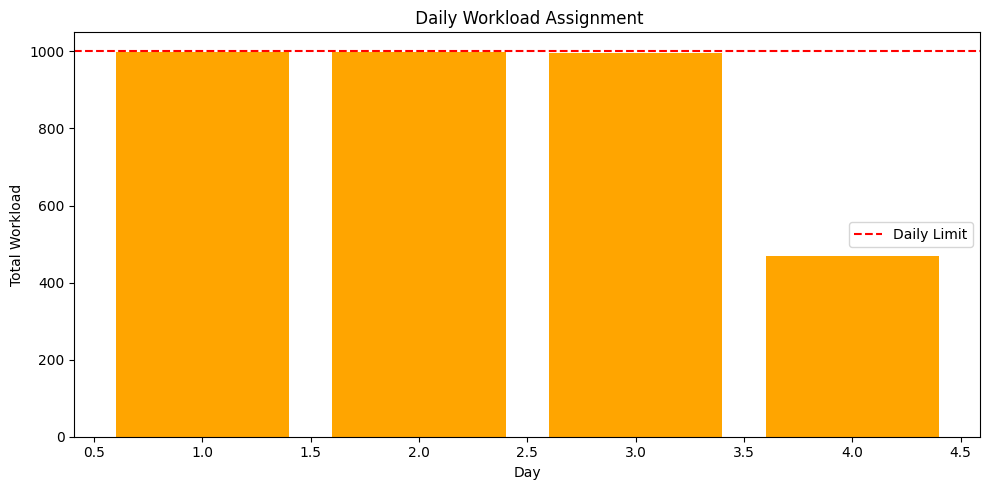

In [80]:
# 🧮 Parameters
DAILY_CAPACITY = 1000  # Max workload one can handle in a day


#df['pword_count'] = df['task_processed'].apply(lambda x: len(x.split()))
df['workload_score'] = ((df['priority_numeric'] + 1)*2) * (df['word_count'] ** 0.4)



# Sort tasks in descending order of workload (optional: keep original order)
df_sorted = df.sort_values(by='workload_score', ascending=False).reset_index(drop=True)

# ⏳ Assign tasks day-by-day
assigned_days = []
day = 1
current_load = 0

for _, row in df_sorted.iterrows():
    score = row['workload_score']
    if current_load + score > DAILY_CAPACITY:
        day += 1
        current_load = 0
    assigned_days.append(day)
    current_load += score

# Add assignment to DataFrame
df_sorted['day_assigned'] = assigned_days
# Total workload per day
workload_per_day = df_sorted.groupby('day_assigned')['workload_score'].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(workload_per_day.index, workload_per_day.values, color='orange')
plt.axhline(DAILY_CAPACITY, color='red', linestyle='--', label='Daily Limit')
plt.xlabel("Day")
plt.ylabel("Total Workload")
plt.title(" Daily Workload Assignment")
plt.legend()
plt.tight_layout()
plt.show()


In [81]:
for day in range(1, day + 1):
    print(f"\n📆 Day {day} — Total Tasks: {(df_sorted['day_assigned'] == day).sum()}")
    for task in df_sorted[df_sorted['day_assigned'] == day]['task_clean'].head(10):
        print(" -", task)



📆 Day 1 — Total Tasks: 97
 - fix bug in project module
 - fix bug in home module
 - fix bug in manager module
 - fix bug in parents module
 - fix bug in home module
 - fix bug in home module
 - buy groceries for dentist
 - transfer money to project
 - check doctor account balance
 - send report to dentist

📆 Day 2 — Total Tasks: 124
 - update project documentation
 - attend parents class
 - do project workout
 - clean the doctor
 - attend bank class
 - take manager medicine
 - attend manager class
 - schedule gym appointment
 - schedule home appointment
 - budget for manager

📆 Day 3 — Total Tasks: 155
 - transfer money to home
 - go for home checkup
 - plan trip to bank
 - check parents account balance
 - deploy changes to doctor
 - review notes for dentist
 - deploy changes to manager
 - send report to dentist
 - work on doctor project
 - go for bank checkup

📆 Day 4 — Total Tasks: 124
 - take bank medicine
 - take manager medicine
 - submit friend assignment
 - update dentist docum

In [85]:
import joblib

joblib.dump(svm_model, "best_category_model.pkl")  # or nb_model
joblib.dump(rf_model, "best_priority_model.pkl")  # or xgb_best_model
joblib.dump(tfidf, "vectorizer.pkl")
joblib.dump(label_encoder, "category_encoder.pkl")
print("imported")

imported
